# ZADANIE
**Autori: Roland Rajcsányi, Jakub František Setnický**

Fáza 2: Predspracovanie (max. 21b)
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte csv) vo vhodnom tvare pre strojové učenie.

To znamená, že jedno pozorovanie musí byť opísané jedným riadkom tabuľky;
V tretej fáze budeme pracovať s algoritmom(-ami), ktorého(ých) implementácia podporuje len numerické dáta, je možné že bude potrebné všetky nenumerické atribúty transformovať na numerické.
Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby.
Významnú časť hodnotenia bude predstavovať znovupoužiteľnosť (replikovateľnosť) predspracovania.
V druhej fáze sa od Vás očakáva:

Integrácia dát a prípadná deduplikácia záznamov (5b).

Výsledkom by mala byť jednotná tabuľková reprezentácia dát, ktorá bude predstavovať vstup pre ďalšie spracovanie a (v 3. fáze) strojové učenie.

Realizácia predspracovania dát a ich zdokumentovanie (6b).

Pri riešení chýbajúcich hodnôt vyskúšajte rôzne stratégie (minimálne 1 stratégiu z 2 nasledujúcich podskupín):
nahradenie chýbajúcej hodnoty mediánom, priemerom alebo pomerom ku korelovanému atribútu
nahradenie chýbajúcej hodnoty priemerom segmentu, pomocou jednoduchej lineárnej regresie alebo k-najbližších susedov (kNN)
Podobne postupujte aj pri riešení vychýlených hodnôt (outlier):
odstránenie vychýlených (odľahlých) pozorovaní
nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)
Transformácia atribútu/ov pomocou Power transform (logaritmus, odmocnina a pod.)
Znovupoužiteľnosť predspracovania (5b).

Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovupoužiť na predspracovanie validačnej/testovacej množiny (napr. pomocou funkcie/í)
Očakáva sa aj využitie možnosti sklearn.pipeline.
Opätovná realizácia podstatných častí prieskumnej analýzy (5b).

Očakáva sa že dokumentujete zmeny distribúcie hodnôt po realizácii predspracovania
Následne dokumentujete LEN zmeny v prieskumnej analýze
Správa sa odovzdáva v 9. týždni semestra na cvičení. Dvojica svojmu cvičiacemu odprezentuje vykonané predspracovanie v Jupyter Notebooku). Následne správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 22.11.2020 23:59.

In [331]:
import matplotlib.pyplot as plt
import pylab as py
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from numpy.random import seed
from numpy.random import rand
from numpy.random import randn
from numpy import mean
from numpy import var
from math import sqrt
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import math
from datetime import date

Nacitanie datasetov na predspracovanie

In [332]:
personal_data = pd.read_csv("Dataset/personal_train.csv")
other_data = pd.read_csv("Dataset/other_train.csv")
current_date = date.today()

Funkcia ktora zavola vsetky potrebne upravovacie funkcie a vytvori finalny dataset a exportuje ho do .csv

In [333]:
def prepare_data(personal_data, other_data):
    # remove unwanted column
    if 'Unnamed: 0' in personal_data:
        del personal_data['Unnamed: 0']
    if 'Unnamed: 0' in other_data:
        del other_data['Unnamed: 0']
    # merge datasets to create single large dataset with usefull data so it's easier to create graphs and analysis
    merged_medical_info_dataset = get_aggregated_data(other_data)
    usefull_dataset = personal_data.merge(merged_medical_info_dataset, on=['name', 'address'], how='outer')
    # replace NaN values with medians for numeric or most frequent values for categorical values
    usefull_dataset = remove_nans(usefull_dataset)
    #backup values of class before scaling data
    backup_class = usefull_dataset[['age', 'class']]
    # reduce number of features to improve performance
    usefull_dataset = feature_reduction(usefull_dataset)
    
    # detect and correct outliers
    usefull_dataset = outlier_detection(usefull_dataset)
    # scale and transform data
    usefull_dataset = transform(usefull_dataset)
    # remap class values
    usefull_dataset['class'] = backup_class['class'].values
    #export
    usefull_dataset.to_csv('Dataset/preprocessed_dataset' + current_date.strftime("%b-%d-%Y") +'.csv', index=False)
    return usefull_dataset


Funkcia na vytiahnutie a nacitanie agragovvanych udajov v datasete

In [334]:
def get_aggregated_data(dataset):
    unique_medical_name_dataset = dataset.dropna(subset=['medical_info']).drop_duplicates('name')
    # create a dataset from 'medical_info' attribute transform it to JSON format and read as object to create dataframe
    medical_data_objects = []
    for index, record in unique_medical_name_dataset.iterrows():
        if isinstance(record['medical_info'], float):
            continue
        medical_object = json.loads(record['medical_info'].replace("\'", '\"').replace(':\"',':').replace('\",',',').replace('\"}','}'))
        medical_object['name'] = record['name']
        medical_data_objects.append(medical_object)
    medical_info_dataset = pd.DataFrame(medical_data_objects)
    merged_medical_info_dataset = unique_medical_name_dataset.merge(medical_info_dataset, on=['name'], how='outer').drop('medical_info', axis='columns')
    return merged_medical_info_dataset

Remove NaN values


In [335]:
def remove_nans(dataset):
    test = dataset
    test = test[test['class'].isnull()==False]
    test.replace('?',np.NaN,inplace=True)
    X = test.drop('class', axis=1)
    y = test['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    numeric_features = test.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = test.select_dtypes(include=['object']).columns
    # with pipeline apply imputers for categorical and numeric values and replace missing data according to strategy
    num = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan,strategy='median'))])
    cat = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan,strategy='most_frequent'))])
    full = ColumnTransformer(
        transformers=[
            ('num',  num, numeric_features),
            ('cat', cat, categorical_features)])

    columns = numeric_features.tolist() + categorical_features.tolist()
    dtype = {}
    for column in columns:
        dtype[column]=(test.dtypes.to_dict()[column])

    return pd.DataFrame(full.fit_transform(test), columns=columns,index=test.index).astype(dtype)

# Feature reduction

Funkcia na zredukovanie nepotrebnych atributov a vyselektovanie k najlepsich atributov ktore najviac kontribuuju k spravnej predpovedi vysledku

In [336]:
def feature_reduction(dataset):
    test = dataset
    test = test[test['class'].isnull()==False]
    test.replace('?',np.NaN,inplace=True)
    
    numeric_features = test.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = test.select_dtypes(include=['object']).columns
    columns_to_remove = ['name', 'education-num', 'capital-gain', 'capital-loss', 'address', 'date_of_birth', 'occupation', 'marital-status','relationship', 'education', 'workclass', 'income', 'race', 'native-country']

    dataset['pregnant'] = dataset['pregnant'].apply(lambda value: 0 if re.search('T', value, re.IGNORECASE) else 1)
    # manualne odstranenie stlpcov ktore podla nas nemaju vplyv na vyslednu hodnotu (vacsinou kategoricke atributy)
    dataset_for_UST = dataset.drop(columns_to_remove, axis=1, errors='ignore')
    columns_to_remove.append('pregnant')
    categorical_features = categorical_features.drop(columns_to_remove, errors='ignore')

    dataset_for_UST = pd.get_dummies(dataset_for_UST, columns=categorical_features)

    # Feature Selection with Univariate Statistical Tests
    # pouzijeme statisticke tety aby sme vybrali K najlepsich atributov ktore najviac vplyvaju na vysledok
    k_values = 14
    UST_X = dataset_for_UST.drop('class', axis=1)
    UST_y = dataset_for_UST['class']
    # feature extraction
    test = SelectKBest(score_func=f_classif, k=k_values)
    fit = test.fit(UST_X, UST_y)
    # summarize scores
    #vidime ze niektore atributy maju miniaturny vplyv na vysledok priam az zanedbatelny tak ich vyhodime aby sme zrychlili vypocet modelu
    
    features_columns = {}
    for i in range(len(fit.scores_)):
        features_columns[UST_X.columns[i]] = fit.scores_[i]
    print(len(features_columns))
    columns_by_rank = {k: features_columns[k] for k in sorted(features_columns, key=features_columns.get, reverse=True)}
    if k_values < len(features_columns):
        columns_to_remove = list(columns_by_rank.keys())[k_values-len(features_columns):]
    else:
        columns_to_remove = []
    return dataset_for_UST.drop(columns_to_remove, axis=1, errors='ignore')

# Odstranenie outlierov
zvolili sme metodu IRQ na detekciu outlierov a hodnoty ktore su outlieri nahradime krajnymi hodnotami

In [337]:
def outlier_detection(dataset):
    for column in dataset.columns:
        Q1 = dataset[column].quantile(0.25)
        Q3 = dataset[column].quantile(0.75)

        IRQ = Q3 - Q1

        lower_bound = Q1 - (1.5*IRQ)
        upper_bound = Q3 + (1.5*IRQ)
        if(dataset[column].dtype == 'int64'):
            dataset[column] = dataset[column].apply(lambda val: math.floor(lower_bound) if val < lower_bound else math.floor(upper_bound) if val > upper_bound else val)
        else:
            dataset[column] = dataset[column].apply(lambda val: lower_bound if val < lower_bound else upper_bound if val > upper_bound else val)
        
        return dataset

# Data transofrmation

pouzijeme Robust scaler na transformaciu dat do podobnych rozsahov a power transformer na transformaciu rozdelenia dat blizsie ku normalovej distribucii

In [338]:
def transform(dataset):
    scaler = RobustScaler()
    scaled = scaler.fit_transform(dataset)
    dataset = pd.DataFrame(scaled, columns=dataset.columns)

    power = PowerTransformer(method='yeo-johnson', standardize=True) 
    data_trans = power.fit_transform(dataset)
    return pd.DataFrame(data_trans, columns=dataset.columns)

In [339]:
dataset = prepare_data(personal_data, other_data)
dataset.info()

14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3923 entries, 0 to 3922
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3923 non-null   float64
 1   kurtosis_oxygen   3923 non-null   float64
 2   std_oxygen        3923 non-null   float64
 3   skewness_oxygen   3923 non-null   float64
 4   fnlwgt            3923 non-null   float64
 5   class             3923 non-null   float64
 6   mean_oxygen       3923 non-null   float64
 7   hours-per-week    3923 non-null   float64
 8   mean_glucose      3923 non-null   float64
 9   std_glucose       3923 non-null   float64
 10  kurtosis_glucose  3923 non-null   float64
 11  skewness_glucose  3923 non-null   float64
 12  pregnant          3923 non-null   float64
 13  sex_ Female       3923 non-null   float64
 14  sex_ Male         3923 non-null   float64
dtypes: float64(15)
memory usage: 459.9 KB


Pozrieme sa na symetrickost a rozdelenie jednotlivych atributov v spracovanom datasete

In [340]:
for column in dataset.columns:
    skewness = stats.skew(dataset[column])
    tab = 20 - len(column)
    if skewness <= 0.5 and skewness >= -0.5:
        print(column,' ' * tab, 'symmetrical    ', skewness)
    elif skewness < -0.5:
        print(column,' ' * tab, 'negative skew  ', skewness)
    else:
        print(column,' ' * tab, 'positive skew  ', skewness)

for column in dataset.columns:
    kurtosis = stats.kurtosis(dataset[column])
    tab = 20 - len(column)
    if kurtosis <= 3.5 and kurtosis >= 2.5:
        print(column,' ' * tab, 'symmetrical    ', skewness)
    elif skewness < 2.5:
        print(column,' ' * tab, 'in middle      ', skewness)
    else:
        print(column,' ' * tab, 'on outer       ', skewness)

age                   symmetrical     0.00980440512294144
kurtosis_oxygen       symmetrical     0.08441268301841127
std_oxygen            symmetrical     0.262335664656167
skewness_oxygen       symmetrical     0.16191212718119571
fnlwgt                symmetrical     0.0330167921828616
class                 positive skew   1.1201604135483203
mean_oxygen           positive skew   0.6532885481086179
hours-per-week        symmetrical     0.1440387829129796
mean_glucose          symmetrical     -0.09709175459822554
std_glucose           symmetrical     0.11196635041826286
kurtosis_glucose      negative skew   -0.521798281765532
skewness_glucose      symmetrical     0.3502761373496034
pregnant              negative skew   -6.83218701126852
sex_ Female           positive skew   0.6753047209399862
sex_ Male             negative skew   -0.6753047209399862
age                   in middle       -0.6753047209399862
kurtosis_oxygen       in middle       -0.6753047209399862
std_oxygen            in

# Prieskumna analyza
2 Datasety sme spojili do jedneho a odstranili sme duplicitne hodnoty a nulove hodnoty pre atribut class ktory je pre nas klucovy a nemozeme ho doplnit

Dalej sme zredukovali pocet atributov na take ktore najviac kontribuuju k vysledku a cyhodili take ktore pravdepodobne vobec nekontribuuju.
¨
Data sme taktiez transformovali aby sa viac podobali normalnej distribucii a pochadzali z podobnych rozsahov hodnot.

Tieto transformacie zmenili vyzor dat a v nasledujucej sekcii sa pozrieme na to ako sa zmenili distribucie a dalsie statisticke atributy dat.

In [341]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3923 entries, 0 to 3922
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3923 non-null   float64
 1   kurtosis_oxygen   3923 non-null   float64
 2   std_oxygen        3923 non-null   float64
 3   skewness_oxygen   3923 non-null   float64
 4   fnlwgt            3923 non-null   float64
 5   class             3923 non-null   float64
 6   mean_oxygen       3923 non-null   float64
 7   hours-per-week    3923 non-null   float64
 8   mean_glucose      3923 non-null   float64
 9   std_glucose       3923 non-null   float64
 10  kurtosis_glucose  3923 non-null   float64
 11  skewness_glucose  3923 non-null   float64
 12  pregnant          3923 non-null   float64
 13  sex_ Female       3923 non-null   float64
 14  sex_ Male         3923 non-null   float64
dtypes: float64(15)
memory usage: 459.9 KB


In [342]:
dataset['age'].describe()

count    3.923000e+03
mean    -9.508920e-18
std      1.000127e+00
min     -2.623916e+00
25%     -6.850024e-01
50%     -8.142723e-03
75%      6.926925e-01
max      2.894961e+00
Name: age, dtype: float64

In [343]:
dataset['kurtosis_oxygen'].describe()

count    3.923000e+03
mean    -1.448978e-17
std      1.000127e+00
min     -2.392692e+00
25%     -7.795640e-01
50%      1.584484e-01
75%      6.519782e-01
max      4.335670e+00
Name: kurtosis_oxygen, dtype: float64

In [344]:
dataset['std_oxygen'].describe()

count    3.923000e+03
mean    -3.622446e-18
std      1.000127e+00
min     -2.080508e+00
25%     -8.273230e-01
50%     -2.098999e-01
75%      9.750437e-01
max      1.844662e+00
Name: std_oxygen, dtype: float64

In [345]:
dataset['skewness_oxygen'].describe()

count    3.923000e+03
mean    -3.441323e-17
std      1.000127e+00
min     -1.404276e+00
25%     -1.009693e+00
50%      9.834362e-02
75%      7.586048e-01
max      2.967157e+00
Name: skewness_oxygen, dtype: float64

In [346]:
dataset['mean_oxygen'].describe()

count    3.923000e+03
mean     1.630101e-17
std      1.000127e+00
min     -1.570784e+00
25%     -7.759811e-01
50%     -4.023385e-01
75%      8.870142e-01
max      1.833087e+00
Name: mean_oxygen, dtype: float64

In [347]:
dataset['std_glucose'].describe()

count    3.923000e+03
mean    -1.992345e-17
std      1.000127e+00
min     -2.505515e+00
25%     -6.639532e-01
50%      8.044572e-02
75%      6.769560e-01
max      6.327571e+00
Name: std_glucose, dtype: float64

In [348]:
dataset['kurtosis_glucose'].describe()

count    3.923000e+03
mean     1.358417e-17
std      1.000127e+00
min     -9.077786e+00
25%     -5.985391e-01
50%     -1.306800e-01
75%      4.273540e-01
max      2.158126e+00
Name: kurtosis_glucose, dtype: float64

In [349]:
dataset['skewness_glucose'].describe()

count    3.923000e+03
mean     4.890302e-17
std      1.000127e+00
min     -4.226775e+00
25%     -7.481600e-01
50%     -2.155608e-01
75%      6.652581e-01
max      1.924899e+00
Name: skewness_glucose, dtype: float64

Mozeme si vsimnut ze vsetky atributy maju velmi pdobne rozsahy ale velmi rozdielne priemery avsak podobne standardne distribucie. toto je vysledok transformacii

In [350]:
# sns.pairplot(dataset, hue='class', kind='reg')

Kedze je cely dataset uz ako numericke hodnoty mozeme ho naraz vyhodnotit pre korelacia meddzi atributmi

In [351]:
dataset.corr()

,age,kurtosis_oxygen,std_oxygen,skewness_oxygen,fnlwgt,class,mean_oxygen,hours-per-week,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,pregnant,sex_ Female,sex_ Male
age,1.000000,-0.222032,0.236484,-0.220742,-0.001180,0.368699,0.250897,-0.015737,-0.010175,-0.147119,0.267361,0.249309,-0.006880,0.010911,-0.010911
kurtosis_oxygen,-0.222032,1.000000,-0.953808,0.978828,0.000197,-0.588910,-0.956404,-0.014661,-0.026147,0.248776,-0.444770,-0.437462,-0.024884,0.011264,-0.011264
std_oxygen,0.236484,-0.953808,1.000000,-0.972310,0.004114,0.640311,0.969433,0.011380,0.035939,-0.263868,0.473689,0.464923,0.030400,-0.014828,0.014828
skewness_oxygen,-0.220742,0.978828,-0.972310,1.000000,-0.000620,-0.589816,-0.944801,-0.012540,-0.032857,0.246633,-0.437836,-0.426554,-0.027081,0.011772,-0.011772
fnlwgt,-0.001180,0.000197,0.004114,-0.000620,1.000000,0.018092,0.007119,-0.020190,0.017364,-0.015642,0.007879,0.018175,-0.012673,-0.042663,0.042663
class,0.368699,-0.588910,0.640311,-0.589816,0.018092,1.000000,0.672759,0.022838,0.018641,-0.496731,0.745714,0.744789,0.009143,0.003619,-0.003619
mean_oxygen,0.250897,-0.956404,0.969433,-0.944801,0.007119,0.672759,1.000000,0.009363,0.029805,-0.286229,0.516362,0.506538,0.027767,-0.010025,0.010025
hours-per-week,-0.015737,-0.014661,0.011380,-0.012540,-0.020190,0.022838,0.009363,1.000000,0.032454,-0.011663,0.029471,0.023437,0.022041,-0.235818,0.235818
mean_glucose,-0.010175,-0.026147,0.035939,-0.032857,0.017364,0.018641,0.029805,0.032454,1.000000,0.006272,0.001070,-0.006275,-0.002581,0.012868,-0.012868
std_glucose,-0.147119,0.248776,-0.263868,0.246633,-0.015642,-0.496731,-0.286229,-0.011663,0.006272,1.000000,-0.608273,-0.859967,0.008080,-0.020535,0.020535


In [352]:
dataset.cov()

,age,kurtosis_oxygen,std_oxygen,skewness_oxygen,fnlwgt,class,mean_oxygen,hours-per-week,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,pregnant,sex_ Female,sex_ Male
age,1.000255,-0.222089,0.236544,-0.220798,-0.001181,0.160881,0.250961,-0.015741,-0.010178,-0.147156,0.267429,0.249373,-0.006881,0.010914,-0.010914
kurtosis_oxygen,-0.222089,1.000255,-0.954051,0.979077,0.000197,-0.256971,-0.956648,-0.014665,-0.026154,0.248840,-0.444883,-0.437573,-0.024890,0.011267,-0.011267
std_oxygen,0.236544,-0.954051,1.000255,-0.972558,0.004115,0.279399,0.969680,0.011383,0.035948,-0.263935,0.473810,0.465041,0.030408,-0.014832,0.014832
skewness_oxygen,-0.220798,0.979077,-0.972558,1.000255,-0.000620,-0.257366,-0.945042,-0.012543,-0.032866,0.246696,-0.437948,-0.426663,-0.027088,0.011775,-0.011775
fnlwgt,-0.001181,0.000197,0.004115,-0.000620,1.000255,0.007894,0.007121,-0.020195,0.017369,-0.015646,0.007881,0.018180,-0.012677,-0.042673,0.042673
class,0.160881,-0.256971,0.279399,-0.257366,0.007894,0.190352,0.293558,0.009965,0.008134,-0.216748,0.325392,0.324988,0.003990,0.001579,-0.001579
mean_oxygen,0.250961,-0.956648,0.969680,-0.945042,0.007121,0.293558,1.000255,0.009365,0.029813,-0.286302,0.516494,0.506667,0.027774,-0.010027,0.010027
hours-per-week,-0.015741,-0.014665,0.011383,-0.012543,-0.020195,0.009965,0.009365,1.000255,0.032463,-0.011666,0.029478,0.023443,0.022047,-0.235878,0.235878
mean_glucose,-0.010178,-0.026154,0.035948,-0.032866,0.017369,0.008134,0.029813,0.032463,1.000255,0.006274,0.001070,-0.006276,-0.002582,0.012872,-0.012872
std_glucose,-0.147156,0.248840,-0.263935,0.246696,-0.015646,-0.216748,-0.286302,-0.011666,0.006274,1.000255,-0.608429,-0.860186,0.008082,-0.020540,0.020540


### Parova analyza a zistovanie zavislosti veku(age) a sklonu glukozy(skewness_glucose)

pozrieme sa na to ako vyzeraju distribucie tychto atributov a nasledne ich zanalyzujeme

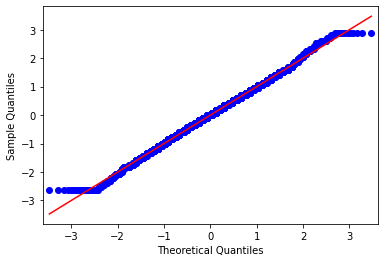

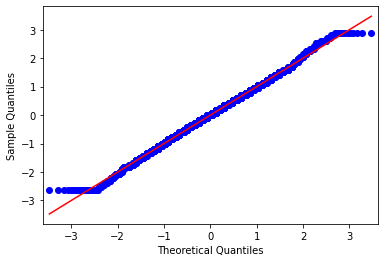

In [353]:
sm.qqplot(dataset['age'], line='s')

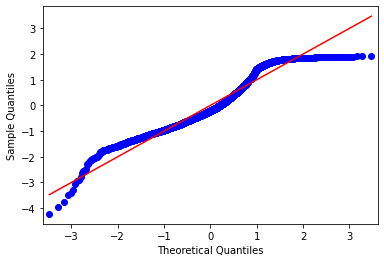

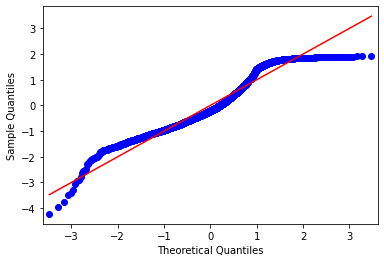

In [354]:
sm.qqplot(dataset['skewness_glucose'], line='s')

skewness_glucose z predoslej analyzy

![skewness_glucose](./skewness_glucose.png)

Atribut vek vyzera ako by mohol pochadzat z normalnej distribucie aj ked chvosty sa uz odklanaju

Atribut skewness glucose ma odlahle chvosty ale vdaka transformacii je to menej odchylene ako pred transformaciou

<AxesSubplot:xlabel='age', ylabel='skewness_glucose'>

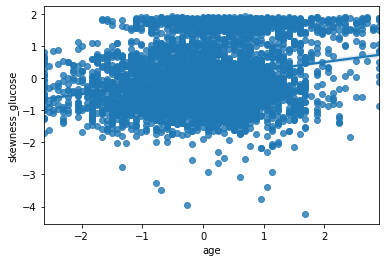

In [355]:
sns.regplot(x=dataset['age'], y=dataset['skewness_glucose'])

In [356]:
corr, _ = stats.pearsonr(dataset['age'], dataset['skewness_glucose']) 
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.249


pre atributy age a skewness glucose sa nam corelacia takmer nezmenila predtym: 0.250

In [357]:
from scipy.stats import kruskal

stat, p =kruskal(dataset['age'], dataset['skewness_glucose'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=7.527, p=0.006
Different distributions (reject H0)


In [358]:
shapiro_test = stats.shapiro(dataset['age'])
print(shapiro_test)

# interpret
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Another distributions (reject H0)')

ShapiroResult(statistic=0.9971759915351868, pvalue=1.1029380857507931e-06)
Another distributions (reject H0)


In [359]:
shapiro_test = stats.shapiro(dataset['skewness_glucose'])
print(shapiro_test)

# interpret
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Another distributions (reject H0)')

ShapiroResult(statistic=0.9490116834640503, pvalue=6.786640296216296e-35)
Another distributions (reject H0)


Parova analyza mean_glucose a mean_oxygen

In [360]:
corr, _ = stats.pearsonr(dataset['mean_oxygen'], dataset['mean_glucose']) 
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.030


Pre tieto atributy sa nam zmenila korelacia viac a to z -0.322 na 0.030 moze to byt dosledkom odstranenia outlierov ktori tlacili korelaciu do negativnych hodnot

In [361]:
from scipy.stats import kruskal

stat, p =kruskal(dataset['mean_oxygen'], dataset['mean_glucose'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=297.106, p=0.000
Different distributions (reject H0)


In [362]:
shapiro_test = stats.shapiro(dataset['mean_oxygen'])
print(shapiro_test)

# interpret
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Another distributions (reject H0)')

ShapiroResult(statistic=0.8743315935134888, pvalue=0.0)
Another distributions (reject H0)


In [363]:
shapiro_test = stats.shapiro(dataset['mean_glucose'])
print(shapiro_test)

# interpret
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print('Normal distribution (fail to reject H0)')
else:
    print('Another distributions (reject H0)')

ShapiroResult(statistic=0.4231971502304077, pvalue=0.0)
Another distributions (reject H0)


In [364]:
X = dataset.drop('class', axis=1)
y = dataset['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)

    print(classifier)
    # print("model score: %.3f" % pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)

    falseP = 0
    falseN = 0
    for i in range(len(y_pred)):
        if y_pred[i] != y_test.tolist()[i]:
            if y_pred[i] == 1:
                falseP += 1
            else: 
                falseN += 1
    print("False Positive: {}".format(falseP))
    print("False Negative: {}".format(falseN))
    print()

RandomForestClassifier()
False Positive: 5
False Negative: 26

AdaBoostClassifier()
False Positive: 13
False Negative: 27

GradientBoostingClassifier()
False Positive: 4
False Negative: 25

